In [25]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

![](Capture.PNG)

Although we won't do the part where C's go directly into the final layer too because we're here for educational content, not minmaxing :flushed:

In [26]:
# read in words
words = open('../2 - makemore/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [27]:
len(words)

32033

In [28]:
# Build the vocab of characters and mappings of char <-> ints
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)} # string to integer
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()} # int to string
print(itos, '\n', stoi)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'} 
 {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [79]:
# Building the dataset

def generate_dataset(words, block_size, doprint=False):
	"returns X, Y datasets based on words list"
	#block_size: context length: how many characters do we take to predict the next one?

	X, Y = [], []

	for w in words:
		if doprint:
			print(w)	
		context = [0] * block_size # this would make [0, 0, ...] based on block_size

		for ch in w + '.': 
			ix = stoi[ch] # index of char
			X.append(context)
			Y.append(ix)
			
			if doprint:
				print(''.join(itos[i] for i in context), '------>', itos[ix])
			context = context[1:] + [ix] # [0,0,0] -> [0,0, ix] like a rolling effect

	X = torch.tensor(X)
	Y = torch.tensor(Y)
	print(X.shape, Y.shape)
	return X, Y
X, Y = generate_dataset(words[:5], 3, True)


ebrima
... ------> e
..e ------> b
.eb ------> r
ebr ------> i
bri ------> m
rim ------> a
ima ------> .
hilton
... ------> h
..h ------> i
.hi ------> l
hil ------> t
ilt ------> o
lto ------> n
ton ------> .
jhene
... ------> j
..j ------> h
.jh ------> e
jhe ------> n
hen ------> e
ene ------> .
manahil
... ------> m
..m ------> a
.ma ------> n
man ------> a
ana ------> h
nah ------> i
ahi ------> l
hil ------> .
naiah
... ------> n
..n ------> a
.na ------> i
nai ------> a
aia ------> h
iah ------> .
torch.Size([34, 3]) torch.Size([34])


In [30]:
print(X.shape, X.dtype, Y.shape, Y.dtype)
X, Y # Each X[n] maps to a Y[n], that's a training example. So you wanna take the X, predict the Y (via NN once again).

torch.Size([32, 3]) torch.int64 torch.Size([32]) torch.int64


(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         [ 5, 13, 13],
         [13, 13,  1],
         [ 0,  0,  0],
         [ 0,  0, 15],
         [ 0, 15, 12],
         [15, 12,  9],
         [12,  9, 22],
         [ 9, 22,  9],
         [22,  9,  1],
         [ 0,  0,  0],
         [ 0,  0,  1],
         [ 0,  1, 22],
         [ 1, 22,  1],
         [ 0,  0,  0],
         [ 0,  0,  9],
         [ 0,  9, 19],
         [ 9, 19,  1],
         [19,  1,  2],
         [ 1,  2,  5],
         [ 2,  5, 12],
         [ 5, 12, 12],
         [12, 12,  1],
         [ 0,  0,  0],
         [ 0,  0, 19],
         [ 0, 19, 15],
         [19, 15, 16],
         [15, 16,  8],
         [16,  8,  9],
         [ 8,  9,  1]]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
          1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

### Embedding our inputs
This is the first step of the NN -- basically, converting our indexes to some embedding.


In [31]:
C = torch.randn((27, 2)) # long chocolate bar 
C[5]

tensor([-0.4761, -0.6478])

In [32]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C # It's the same thing as indexing, because that's how matrix mult works, and how one hot encodes (remember, just, a vector of 0s  except for the 1 at index 5.) So there's multiple ways you can interpret this. For now, we'll use indexing because it's faster.

tensor([-0.4761, -0.6478])

In [33]:
C[[5,6,7]] # We can index multiple things at once, X here we come!!

tensor([[-0.4761, -0.6478],
        [-1.6218, -0.2315],
        [-0.4473,  1.0223]])

In [34]:
emb = C[X] # Can even do multidimensional indexing
print(emb.shape)
"""
This gives us the embedding for every example of X (of which, each example has 3 inputs).
"""
print(f"Ex: For example 13, the 2nd char index is {X[13, 2]}, and that has an embedding of {emb[13, 2]}, and we can see it's the same as {C[1]=}")

torch.Size([32, 3, 2])
Ex: For example 13, the 2nd char index is 1, and that has an embedding of tensor([ 0.0536, -0.5210]), and we can see it's the same as C[1]=tensor([ 0.0536, -0.5210])


### Weights and Layers
Look at the picture. This is the layer that'll get tanh'd -- the above embedding stuff is the look into C and embedding which, which will be our inputs to the NN 

In [35]:
W1 = torch.randn((6, 100)) # as you can see from the embedding, we'll have 6 inputs per example. (3 chars and each char embedded to 2 things).
b1 = torch.randn(100)

# However!
emb @ W1 + b1 # Gives error since we can't multiply (32,3,2) by (6,100)! We have to convert the embed to a (32, 6) matrix.

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [ ]:
print(emb[:, 0, :].shape) # This'll get embedding of all the first character examples. 
""" Now, we'll get all of them in a sequence, and then concat their columns together."""

torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape # And we want to concatenate along the '1' dimension (i.e column wise here). But it's not easily generalisable if we wanted more code blocks. So:
"""OH SHIT! I JUST REALISED WHAT WAY THE DIMENSION NUMBER WORKS. LOL. FUCK ME.
It's just, say you have a torch.Size([a,b,c,d]). a is dim 0, b is dim 1, c is dim 2...
"""

torch.Size([32, 2])


torch.Size([32, 6])

In [ ]:
print(emb.shape) # we unbind along index 1 to combine the way we want to.
print(len(torch.unbind(emb, 1)))

torch.cat(torch.unbind(emb, 1), 1).shape # Unbind here does the same thing as our whole emb sequence above

torch.Size([32, 3, 2])
3


torch.Size([32, 6])

In [ ]:
# ----- Education ------
# # However, we have more efficient way! :o view!
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [ ]:
a.view(18), a.view(2,9), a.view(9,2), a.view(3,3,2) # They all work, and super quick! Just gotta be a*b*... = num of elements total.

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]),
 tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
         [ 9, 10, 11, 12, 13, 14, 15, 16, 17]]),
 tensor([[ 0,  1],
         [ 2,  3],
         [ 4,  5],
         [ 6,  7],
         [ 8,  9],
         [10, 11],
         [12, 13],
         [14, 15],
         [16, 17]]),
 tensor([[[ 0,  1],
          [ 2,  3],
          [ 4,  5]],
 
         [[ 6,  7],
          [ 8,  9],
          [10, 11]],
 
         [[12, 13],
          [14, 15],
          [16, 17]]]))

In [ ]:
print(emb.shape)
print(emb.view(32, 6) ==  torch.cat(torch.unbind(emb, 1), 1)) # It 'views' it in the same way :o
h = emb.view(32, 6) @ W1 + b1
h

####### --------------- Back to main ------------- ############ 


torch.Size([32, 3, 2])
tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [Tr

tensor([[ 2.7268, -3.0981,  3.1197,  ...,  6.5318, -7.7704,  0.0571],
        [ 2.2707, -2.2964,  4.6629,  ...,  5.1119, -7.6003, -0.6592],
        [ 2.6195, -1.4434,  3.9820,  ...,  3.0401, -6.1684, -1.0681],
        ...,
        [-2.2184,  0.0373,  0.8352,  ...,  0.4229,  3.6632, -1.0233],
        [-1.2713,  1.4442,  5.6576,  ..., -2.1889, -1.2700, -1.3892],
        [ 1.2163,  0.8004,  1.0746,  ..., -2.6963,  4.0367, -1.6649]])

In [ ]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # -1 same as emb.shape[0] (infers shit pytorch chad mode) just so we don't hardcode num of examples
print(h)  # nums between -1, 1
print(h.shape)

tensor([[ 0.9915, -0.9959,  0.9961,  ...,  1.0000, -1.0000,  0.0571],
        [ 0.9789, -0.9800,  0.9998,  ...,  0.9999, -1.0000, -0.5779],
        [ 0.9894, -0.8944,  0.9993,  ...,  0.9954, -1.0000, -0.7887],
        ...,
        [-0.9766,  0.0373,  0.6833,  ...,  0.3993,  0.9987, -0.7712],
        [-0.8541,  0.8945,  1.0000,  ..., -0.9752, -0.8538, -0.8830],
        [ 0.8386,  0.6642,  0.7912,  ..., -0.9909,  0.9994, -0.9309]])
torch.Size([32, 100])


----- Educational
just to make sure we  broadcasting right! https://pytorch.org/docs/stable/notes/broadcasting.html

Two tensors are “broadcastable” if the following rules hold:

Each tensor has at least one dimension.

When iterating over the dimension sizes, starting at the trailing dimension, the dimension sizes must either be equal, one of them is 1, or one of them does not exist.

In [ ]:
(emb.view(-1, 6) @ W1).shape, b1.shape
# 32, 100
#  1 , 100 so it'll make this a row vector (it puts the 1 there), and then element wise additions over all 32 examples. We want this in this case -- same bias vector added to all rows of the matrix.
# Good practice to make sure!!!!!

(torch.Size([32, 100]), torch.Size([100]))

 Back to main!!


In [36]:
# Second set of weights -- our final layer in this case!
W2 = torch.randn((100, 27)) # 100 inputs, converts to 27 outputs (27 chars that come next)
b2 = torch.randn(27)

In [37]:
logits = h @ W2 + b2 
logits.shape

NameError: name 'h' is not defined

In [38]:
counts = logits.exp() 
probs = counts / counts.sum(1, keepdim=True)
print(probs.shape,  probs[0].sum()) # Sanity check, sum of each row should equal 1 -- each row is prob dist of next word.

NameError: name 'logits' is not defined

Now we'll get our loss function, simple simple

In [39]:
print(Y, '\n', probs[torch.arange(32), Y]) # The arange goes 0-31, so it'll return the 0-31st row of probs, and Y makes it so we index to the *correct* index, and get the probability of it. Some arw good like a 3.54e-01, but a lot are awful! Let's get the loss now.

loss = -probs[torch.arange(32), Y].log().mean() # hardcoded 32 :(
print(f'{loss=}')

NameError: name 'probs' is not defined

### Sum up of everything above, but respectably

In [40]:
X, Y = generate_dataset(words, 3)
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [103]:
g = torch.Generator().manual_seed(2147483647)
def generate_parameters():
	C = torch.randn(27, 2, generator=g) # le embedding index thingy 
	W1 = torch.randn((6, 100), generator=g)
	b1 = torch.randn(100, generator=g)
	W2 = torch.randn((100, 27), generator=g)
	b2 = torch.randn(27, generator=g)
	parameters = [C, W1, b1, W2, b2] # for easy summing parameters

	for p in parameters:  # Turn on requires grad for our parameter matrices
		p.requires_grad = True
		
	print(sum(p.nelement() for p in parameters)) # num of parameters in total

	return parameters
parameters = generate_parameters()

3481


3481

Educational moment!
So, with cross entropy, the forward pass can be much more efficient, the backward pass can be much more efficient, and can be numerically well behaved
```
logits = torch.tensor([-50, 2, 3, 100])
counts = logits.exp() # poggers time to convert logits to prob distrs!
probs = counts / counts.sum()
probs -> tensor([0., 0., 0., nan])
```
Uh oh! Basically, it goes way over our max positive limit (via exp, literally doing e^100). Small numbers are fine, and since you can +- any arbitrary constant to logits and get the same prob outputs due to the normalisation, cross_entropy basically does a thing where it picks out the max value number in the logits tensor, and subtracts it away so we don't get any sussy baka nans.

Okay, I'm removing the code below and replacing it with F.cross_entropy now :( 
```
	counts = logits.exp() # poggers time to convert logits to prob distrs!
	probs = counts / counts.sum(1, keepdims=True)
	loss = -probs[torch.arange(32), Y].log().mean() # hardcoded 32 :(
```

In [43]:
def forward_pass(params, X):
	C, W1, b1, W2, b2 = params
	# Construct minibatch (of size 32)
	ix = torch.randint(0, X.shape[0], (32,)) # 32 random ints from size of 0- training set
	
	# forward pass
	emb = C[X[ix]] # (32,3,2) here
	h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
	logits = h @ W2 + b2 # (32, 27)

	loss = F.cross_entropy(logits, Y[ix]) # Does the epic normalisation stuff
	# print(f'{loss=}')
	return logits, loss

def train_model(parameters, X, Y):
	""" 
	THIS IS MINIBATCHED UP BTW!!!
	The training section of your parameters -- you gradient descent down this mofo!
	This changed a lot over the course of the video. Like, we have cross entropy instead of the default inefficient normalising way, minibatches, ...
	Yeah.

	Args:
		parameters (_type_): From generate_parameters()
		"""
	C, W1, b1, W2, b2 = parameters
	for _ in range(10):

		# Forward pass -- this is minibatched!
		logits, loss = forward_pass(parameters, X)

		# backward pass - zero grad, backprop
		for p in parameters:
			p.grad = None
		loss.backward()

		# update
		for p in parameters:
			p.data += -0.1 * p.grad
	print(f'{loss=}') # This is the loss for the minibatch rn.
	return parameters


In [44]:
parameters = train_model(parameters, X, Y)
C, W1, b1, W2, b2 = parameters # Just so we can get some fkin 'niceness' between karpathy's going through stuff lecture and us modularising it

loss=tensor(8.0479, grad_fn=<NllLossBackward0>)


In [45]:
# This is just a bit so we can see the whole training set loss and not just the training batch loss
emb = C[X] # (X.shape[0],3,2) here -- whole set in this case
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)

loss = F.cross_entropy(logits, Y) # Does the epic normalisation stuff
print(f'{loss=}')

loss=tensor(10.6975, grad_fn=<NllLossBackward0>)


#### Educational time! Minibatches
At the core -- even though minibatches only approximate the gradient (i.e not as reliable as the full training set), you can take a lot more steps, and it's worth it over the full training set that gets the gradient but you tkae a lot less steps.

Basically, the way you minibatch is you make a range of numbers (of your minibatch size, like 32) between 0-training set size. And then you run the gradient descent on that batch as your 'training set' basically. And you just keep doing that.
~44:00 mins in.
```
ix = torch.randint(0, 5, (32,)) # generates 32 numbers from 0-5. We'll use this idea for minibatches.
```

### Trying to find the best learning rate
This shit's gotta be so confusing for onlookers lmaooo. Okay, anyways. ~46 mins in. Wait. 46???? DUDE. IT'S BEEN LIKE HALF A FUCKING HOUR. GAAAAAAAH
We'll see what learning rates are the best. Time to dismantle the code again :o


In [67]:
X, Y = generate_dataset(words, 3)
parameters = generate_parameters()


In [68]:
lre = torch.linspace(-3, 0, 1000) # generates 1000 points equally distanced between -3, 0. But these will act as the exponentials of the actual things we're gonna plot.count
lrs = 10**lre # exponential spacing :o 

## Gah, I reput everything here because it was bugging out but I just forgot to do -lr instead of lr when I deleted the hardcoded learning rate @.@
# Okay i changed it back fuck me! I gotta use commitign

In [73]:
lri = []  # learning rates we used
lossi = [] # losses due to that learning rate.
C, W1, b1, W2, b2 = parameters
for i in range(10000):
	# Forward pass -- this is minibatched!
	
	# Construct minibatch (of size 32)
	ix = torch.randint(0, X.shape[0], (32,)) # 32 random ints from size of 0- training set
	
	# forward pass
	emb = C[X[ix]] # (32,3,2) here
	h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
	logits = h @ W2 + b2 # (32, 27)

	loss = F.cross_entropy(logits, Y[ix]) # Does the epic normalisation stuff
	# print(f'{loss=}')

	# backward pass - zero grad, backprop
	for p in parameters:
		p.grad = None
	loss.backward()

	# update
	# lr = lrs[i]
	lr = 0.1
	for p in parameters:
		p.data += -lr * p.grad

	# # track stats
	# lri.append(lr)
	# lossi.append(loss.item())


# print(f'{loss=}') # This is the loss for the minibatch rn.

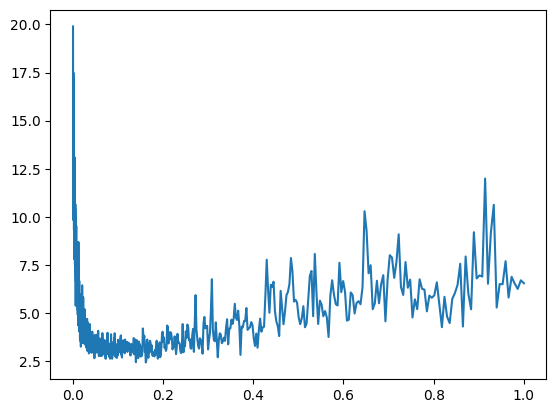

In [59]:
plt.plot(lri, lossi) # Looks like 0.1 is a pretty good learning rate

In [76]:
# Eval the loss on the entire training set
emb = C[X] # (X.shape[0],3,2) here -- whole set in this case
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (blah, 100)

logits = h @ W2 + b2 # (32, 27)

loss = F.cross_entropy(logits, Y) # Does the epic normalisation stuff
print(f'{loss=}')
# Bigram model surpassed, gigachad.
# And now we can start lowering the lr to like 0.01, etc.. so we can getting closer to the min instead of jumping around it.

torch.Size([228146, 100])
loss=tensor(2.4532, grad_fn=<NllLossBackward0>)


### Training split, dev/validation split, test split.
80%, 10%, 10%.
- So training split is for the initial training stage; the gradient descent stuff you just saw above.
- Dev/validation split is for finetuning hyperparameters (number of weights, size of embedding, size of hidden layer, ...)
- test split is for your final evaluation basically -- be careful for overusing this, because, every time you learn something from the test split, you risk overfitting it (because it's info from a split that shouldn't be 'known' to you :o)



In [80]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = generate_dataset(words[:n1], 3)
Xdev, Ydev = generate_dataset(words[n1:n2], 3)
Xte, Yte = generate_dataset(words[n2:], 3)
# Of course, the sizes are way more massive than # word examples because these are the examples from the words (char stuff), not the words themselves.

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [86]:
print(len(words))
print(f"index {n1=}, index {n2=}, so you'd get {n1} training words, {n2-n1} dev words, and {len(words)-n2} test examples")
n1, n2,  # This would be how many training sets, 

32033
index n1=25626, index n2=28829, so you'd get 25626 training words, 3203 dev words, and 3204 test examples


(25626, 28829)

In [176]:
g = torch.Generator().manual_seed(2147483647)
def generate_BIG_parameters():
	# We booosting our hidden layer size
	C = torch.randn(27, 10, generator=g) # le embedding index thingy 
	W1 = torch.randn((30, 200), generator=g)
	b1 = torch.randn(200, generator=g)
	W2 = torch.randn((200, 27), generator=g)
	b2 = torch.randn(27, generator=g)
	parameters = [C, W1, b1, W2, b2] # for easy summing parameters

	for p in parameters:  # Turn on requires grad for our parameter matrices
		p.requires_grad = True
		
	print(sum(p.nelement() for p in parameters)) # num of parameters in total

	return parameters

In [177]:
## Okay, so again, but now we'll train on training set only
X, Y = generate_dataset(words, 3)
# parameters = generate_parameters()
parameters = generate_BIG_parameters()
C = torch.randn(27, 10, generator=g) # 1:08:00 basically final bit of video

lre = torch.linspace(-3, 0, 1000) # generates 1000 points equally distanced between -3, 0
lrs = 10**lre # exponential spacing :o 

torch.Size([228146, 3]) torch.Size([228146])
11897


In [178]:
# lri = []  # learning rates we used
lossi = [] # losses due to that learning rate.
stepi = []

In [183]:
C, W1, b1, W2, b2 = parameters
for i in range(50000):
	# Forward pass -- this is minibatched!
	
	# Construct minibatch (of size 32)
	ix = torch.randint(0, Xtr.shape[0], (32,)) # 32 random ints from size of 0- training set
	
	# forward pass
	emb = C[Xtr[ix]] # (32,3,2) here
	h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100). Hardedcoded af 3*embedding size :flushed:
	logits = h @ W2 + b2 # (32, 27)

	loss = F.cross_entropy(logits, Ytr[ix]) # Does the epic normalisation stuff
	# print(f'{loss=}')

	# backward pass - zero grad, backprop
	for p in parameters:
		p.grad = None
	loss.backward()

	# update
	# lr = lrs[i]
	lr = 0.1 if i < 20000 else 0.01
	for p in parameters:
		p.data += -lr * p.grad

	# # track stats
	# lri.append(lr)
	stepi.append(i)
	lossi.append(loss.log10().item())


# print(f'{loss=}') # This is the loss for the minibatch rn.

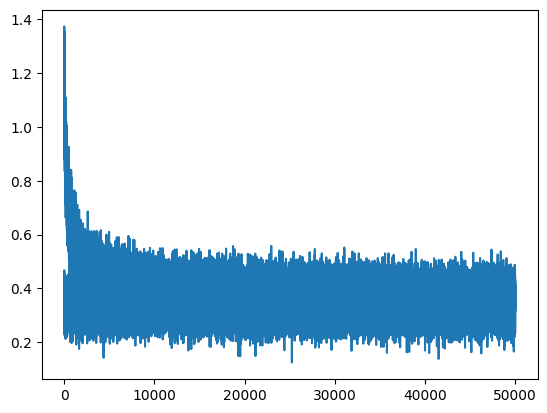

In [185]:
plt.plot(stepi, lossi) # the minibatches are what is creating that bit of noises of look OOOOO EEEEEE OOOOO EEEE fluctuation
# # It could be an idea to increase batchsize so the fluctuation isn't so boobobdobol

In [184]:
print(loss.item()) 

2.2210326194763184


In [186]:
# Evaluating with our dev set
# Eval the loss on the entire training set
def evaluate_loss(X, Y):
	emb = C[X] # (X.shape[0],3,2) here -- whole set in this case
	h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (blah, 100)

	logits = h @ W2 + b2 # (32, 27)

	loss = F.cross_entropy(logits, Y) # Does the epic normalisation stuff
	print(f'{loss=}')
	return loss

train_loss = evaluate_loss(Xtr, Ytr)
dev_loss = evaluate_loss(Xdev, Ydev) # Our train and dev losses are about equal, so we aren't overfitting :D (our model isn't powerful enough to just memorise our training set)

# Actually, since they're almost the same, it indicates our model is underfitting --> indicates our model might be too small. Easiest way to do it is to just increase our hidden layer size, add some more neurons.

### 1:10:000 ooooh our train loss and dev loss is beginning to grow apart!! this is an incidication we're  beginning to overfiit


loss=tensor(2.1711, grad_fn=<NllLossBackward0>)
loss=tensor(2.2166, grad_fn=<NllLossBackward0>)


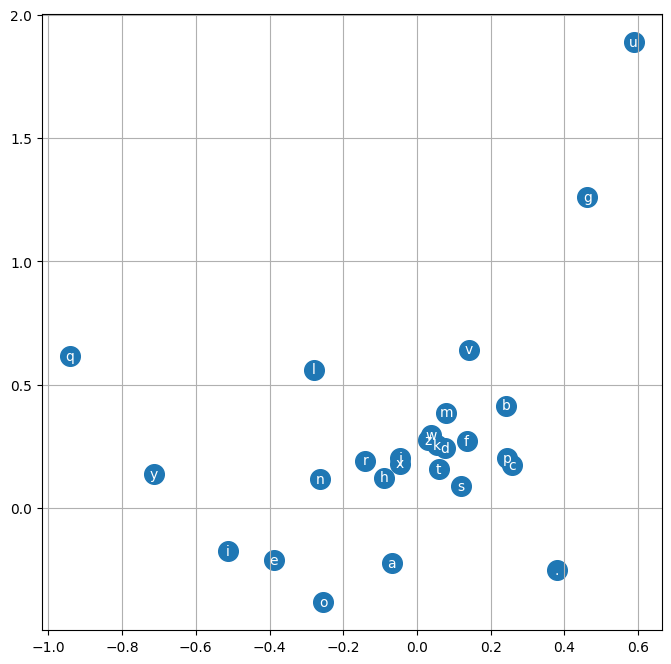

In [155]:
### We can visualise our embeddings rn because it's just 2 dimensions:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

How fuckin cool is that! The embeddings show that it 'sees' the vowels as similar; they are often interchangeable and/or have similar properties. This is learnt!!!! It's a bit different to what karpathy had (in terms of pure numbers), but the clusters are similar -- there's our vowel cluster, '.' is in its little spot because it's not similar to anything, and g is in the fuckin woods -- it's doesn't seem to share similar properties at all!

#### Hmmm, what could be stopping our loss from reducing?
Well, the line of thinking is that -- we're underfitting, and we made the layer size a lot bigger but that didn't really decrease the loss, so it might be due to the embedding size. Let's try improving it. Pog. Changed embedding size.


### Last bit, sampling!!

In [187]:
block_size = 3
context = [0] * block_size
C[torch.tensor([context])].shape # Shape of (1, block_size, embedding_size) yep makes sense!!! # Since it's like, block size is # of chars we're using to predict the next one, embedding size is the... well, embedding size of each char.

torch.Size([1, 3, 10])

In [189]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size, embedding_size)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1) # exponentiates, normalises (sum to one). It's like entropy, but goes from logits -> prob distr, instead of logits -> loss
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carpavela.
jhavi.
kimlyn.
tatyah.
cassie.
mahuen.
delyah.
jareei.
nermara.
chaiir.
kaleigh.
ham.
jory.
quinn.
sulin.
alianni.
wanelo.
dearynix.
kael.
durat.
